In [1]:
%reset
import seaborn as sn
import pandas as pd
import PIL
import io
import numpy as np
import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data
from torch.optim import lr_scheduler
import copy
import time
from collections import defaultdict
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
from torchsummary import summary
from utils.ply import write_ply, read_ply
import utils.alienlab as alien
from torch.nn.parameter import Parameter
from torch.nn import init, Softmax
import math

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


cuda:0


In [2]:
#### Sparse data

In [3]:
#Speed test for sparse or dense method to save and load the features. 5x faster for dense array

if False: 
    import time
    deb = time.time()

    path = 'LEARNING/feature_sparse/arabidopsis_000.pt'
    a = torch.load(path)
    a = torch.sparse.FloatTensor(a[1].unsqueeze(0), a[0], size = torch.Size([72 * 2197000 * 7]))
    a = a.to_dense()
    a = a.reshape((-1, 72, 7))
    gt = torch.load('LEARNING/ground_truth_3D/arabidopsis_3D_GT_000.pt')
    gt = torch.sparse.FloatTensor(gt[0].unsqueeze(0), gt[1], 
                                  size = torch.Size([a.shape[0]])).to_dense()

    fin = time.time()
    print(fin-deb)
    

    deb = time.time()

    path = 'LEARNING/features/arabidopsis_000.pt'
    feat = torch.load(path)
    feat = feat.permute(1, 0, 2)
    feat = torch.flatten(feat, start_dim = 1)
    gt = torch.load('LEARNING/ground_truth_3D/arabidopsis_3D_GT_000.pt')
    gt = torch.sparse.FloatTensor(gt[0].unsqueeze(0), gt[1], 
                                  size = torch.Size([feat.shape[0]])).to_dense()

    fin = time.time()
    print(fin-deb)

In [4]:
# We read the dataset and create an iterable.
class features_from_views(data.Dataset):
    def __init__(self, features_path, gt_path):
        
        self.features = features_path
        self.ground_truth = gt_path
        
        
    def __getitem__(self, index):   # Function that returns one point and one label.
        self.feat = torch.load(self.features[index])
        self.feat = self.feat.permute(1, 0, 2)
        
        #self.feat = torch.flatten(self.feat, start_dim = 1)
        self.gt = torch.load(self.ground_truth[index])
        self.gt = torch.sparse.FloatTensor(self.gt[0].unsqueeze(0), self.gt[1], 
                              size = torch.Size([self.feat.shape[0]])).to_dense()
        k = 100000
        return  self.feat[5*k:20*k], self.gt[5*k:20*k]
        #return self.feat, self.gt
    def __len__(self):   # Length of the dataset.
        return len(self.features)

In [5]:
# We create the dataloader.
path_features = 'LEARNING/feature_blur1/*.pt'
path_ground_truth = 'data/arabidopsis/train/3D_label/*.pt'
list_features = np.sort(glob.glob(path_features))
list_ground_truth = np.sort(glob.glob(path_ground_truth))

T = 5
L = len(list_features)-T
v = 5


#train_features = features_from_views(list_features[9:11], list_ground_truth[9:11])
#val_features = features_from_views(list_features[9:11], list_ground_truth[9:11])

train_features = features_from_views(list_features[:L-v], list_ground_truth[:L-v])
val_features = features_from_views(list_features[L-v:L], list_ground_truth[L-v:L])
test_features = features_from_views(list_features[9:11], list_ground_truth[9:11])

batch_size = 1

feature_loader = data.DataLoader(train_features, batch_size=batch_size, num_workers=0)
val_loader = data.DataLoader(val_features, batch_size=batch_size, num_workers=0)
test_loader = data.DataLoader(test_features, batch_size=batch_size, num_workers=0)

classes = ["Back", "Flower", "Ped", "Stem", "Leaves", "Fruits"]
k = 100000


In [6]:
# Different models tried
class two_layers(nn.Module):
    def __init__(self, n_in = 72*7, n_hid=20, n_out = 7 ):
        super(two_layers,self).__init__()
        self.n_in  = n_in
        self.n_out = n_out
        self.n_hid = n_hid
        self.layer = nn.Linear(self.n_in, self.n_out, bias = True)
        torch.nn.init.xavier_uniform(self.layer.weight)

        self.linear1 = nn.Sequential(self.layer)
    
    def forward(self,x):
        print(x.shape)
        x = x.flatten(start_dim = 2)
        print(x.shape)

        x = F.relu(self.linear1(x))
        print(x.shape)

        # x = self.linear2(x)
       # x = self.logprob(x)
        return x[:,:,:]

    
class convo_1D(nn.Module):
    def __init__(self, n_class = 7):
        super(my_model,self).__init__()
        self.conv1 = torch.nn.Conv1d(n_class, n_class, 3, padding = 1)
        self.maxpool = torch.nn.MaxPool1d(3)
        self.activ = torch.nn.LeakyReLU(negative_slope=0.01)
        self.conv_tot = nn.Sequential(self.conv1, self.maxpool, self.activ,
                                      self.conv1, self.maxpool, self.activ,
                                     self.conv1, self.maxpool, self.activ,
                                     torch.nn.MaxPool1d(2))

    def forward(self,x):
        x = x[0]
        x = F.relu(self.conv_tot(x))
        return x 
    
class w_n_b(nn.Module):
    def __init__(self, n_views = 72, n_class = 7):
        super(my_model,self).__init__()
        self.weight = Parameter(torch.Tensor(1, 1, n_class, n_views))
        self.bias = Parameter(torch.Tensor(1, 1, n_class, n_views))

        self.reset_parameters()
        
    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

        
    def forward(self,x):
        x = x * self.weight + self.bias
        x = F.relu(x)
        x = torch.sum(x, dim = -1)
        return x 

class ax_b(nn.Module):
    def __init__(self, n_views = 72, n_class = 7):
        super(my_model,self).__init__()
        self.weight = torch.ones((1, 1, n_class, n_views)).to(device)
        k = 100000
        self.bias = Parameter(torch.Tensor(1, 5*k, n_class, n_views))

        self.reset_parameters()
        
    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

        
    def forward(self,x):
        x = x * self.weight + self.bias
        x = F.relu(x)
        x = torch.sum(x, dim = -1)
        
        return x 
    
class my_model(nn.Module):
    def __init__(self, n_views = 72, n_class = 7):
        super(my_model,self).__init__()
        self.weight = Parameter(torch.Tensor(1, 1, n_class, n_views).to(device))
        k = 100000
        self.bias = Parameter(torch.Tensor(1, 5*k, n_class))

        self.reset_parameters()
        
    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

        
    def forward(self,x):
        x = x * self.weight
        x = torch.sum(x, dim = -1)
        x = x + self.bias
        x = Softmax(dim=2)(x)
        return x 
    
    
class my_model_simple(nn.Module):
    def __init__(self, n_views = 72, n_class = 7):
        super(my_model_simple,self).__init__()
        self.weight = Parameter(torch.Tensor(1, 1, n_views, n_class).to(device))
        self.bias = Parameter(torch.Tensor(1,5*k,n_class).to(device))
        self.reset_parameters()

        
    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)
            
    def forward(self,x):
        print(x.shape, self.weight.shape)
        x = x * self.weight
        print(x.shape)
        x = torch.sum(x, dim = -2, keepdim = True)
        print(x.shape)
        #x = x + self.bias
        return x[:,:,0,:]

# Taining.
for k, (data, target) in enumerate(feature_loader):
    # Definition of inputs as variables for the net.
    # requires_grad is set False because we do not need to compute the 
    # derivative of the inputs.
    data   = Variable(data,requires_grad=False)
    target = Variable(target.long(),requires_grad=False)
    print(data.shape, target.shape)
    # Set gradient to 0.
    optimizer.zero_grad()
    # Feed forward.
    pred = model(data)
    pred = pred.permute(0, 2, 1)
    # Loss calculation.
    print(pred.max())
    loss = criterium(pred,target)
    # Gradient calculation.
    loss.backward()
    
    # Print loss every 10 iterations.
    if k%10==0:
        print('Loss {:.4f} at iter {:d}'.format(loss.item(),k))
        
    # Model weight modification based on the optimizer. 
    optimizer.step()

In [7]:
def train_model(model, optimizer, scheduler, writer, num_epochs=25):

    
  
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    train_loss = []
    val_loss = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])

                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            #i = -25.
            i = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                #optimizer.param_groups[0]['lr'] = 2**i
                #i = i + 1
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    outputs = outputs.permute(0, 2, 1)
                    #loss = calc_loss(outputs, labels, metrics)
                    loss = criterium(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        train_loss.append(loss.detach().cpu().numpy())

                        
                        
                        train_loss.append(loss)
                    else: 
                        val_loss.append(loss.detach().cpu().numpy())
                        val_loss.append(loss)
                        
                    
                    print(loss, optimizer.param_groups[0]['lr'])
                epoch_samples += inputs.size(0)
            i += 1
            print(loss)
        writer.add_scalar('train/crossentropy', loss, epoch)
        writer.add_scalar('val/crossentropy', loss, epoch)
        label_batch = labels[0].detach().cpu().numpy()
        pred_batch = torch.argmax(outputs[0], dim = 0).detach().cpu().numpy()
        pred_batch[pred_batch == 6] = 0
 
        cm = confusion_matrix(label_batch, pred_batch)
        
        df_cm = pd.DataFrame(cm, index = [i for i in "ABCDEF"],
              columns = [i for i in "ABCDEF"])
        fig = plt.figure(figsize = (10,7))
        sn.heatmap(df_cm, annot=True)
        writer.add_figure('Confusion matrix', fig, epoch)
    
        # deep copy the model
        #if phase == 'val' and epoch_loss < best_loss:
        #    print("saving best model")
        #    best_loss = epoch_loss
        #    best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
        arg = torch.argmax(outputs, dim = 1)
        colors = ['r.', 'k.', 'g.', 'b.', 'o.', 'l.']

        fig = plt.figure(figsize = (10,10))
        ax = plt.axes(projection='3d')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.set_aspect('equal')
        ax.set_title('Ground truth predictions')

        vol = torch.load('voxel_coord/voxels_05_shift6.pt').to(device)
        vol[5*k:20*k,3] = arg[0].cpu()

        corresp = [1,2,3,4,5]
        for i in corresp:
            inds = vol[:,3] == corresp[i-1]
            inds = inds.cpu()
            print(np.count_nonzero(inds))
            pred_label = vol[inds].cpu()
            ax.scatter3D(pred_label[:,0], pred_label[:,1], pred_label[:,2], colors[i-1], s=10)
            i += 1

        writer.add_figure('Segmented flower', fig, epoch)
        
        #weights_a = list(model.parameters())[0].detach()
        #weights_a = weights_a[0, 0:200].view(-1, 1).repeat(1, 10).view(-1, 70)
        #fig = plt.figure()
        #plt.imshow(weights_a.cpu().numpy())
        #writer.add_figure('Weights A', fig, epoch)

    print('Best val loss: {:4f}'.format(loss))
    #writer.add_graph(model, inputs)
    # load best model weights
    #model.load_state_dict(best_model_wts)
    return model, val_loss, train_loss

WAIT

In [8]:
#model = my_model().to(device)
#summary(model, (5*k,7,72))

In [11]:
# Now, we create the mode, the loss function or criterium and the optimizer 
# that we are going to use to minimize the loss.

# Model.
#model = my_model_simple().to(device)
model = two_layers().to(device)

# Negative log likelihood loss.
wb = 1/1e6
wc = 1/1e4
weights = [wb, wc, wc, wc, wb, wc, wb] #[ 1 / number of instances for each class]
class_weights = torch.FloatTensor(weights).cuda()

#criterium = nn.NLLLoss(weights = class_weights)
criterium = nn.CrossEntropyLoss(weight=class_weights)
# Adam optimizer with learning rate 0.1 and L2 regularization with weight 1e-4.
optimizer = torch.optim.Adam(model.parameters(),lr=0.05,weight_decay=1e-4)

batch_size = 4

dataloaders = {
    'train':feature_loader,
    'val': val_loader,
    'test': test_loader
    }
num_class = 6

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.99)
print(device)



name = "classification_trials/shifting_blur1_two_layers_h20_lr_005_wb_1e5_wc_1e4"
writer = SummaryWriter(name)
model = train_model(model, optimizer, exp_lr_scheduler, writer, num_epochs=10)
writer.close()


/home/alienor/Documents/Segmentation/segmentation/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  if __name__ == '__main__':


cuda:0
Epoch 0/9
----------
LR 0.05
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(2.0467, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.05
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.5038, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.05
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.6941, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.05
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.5886, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.05
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.5819, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.05
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.3875, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.05
torch.Size([1, 1500000, 72, 

torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.2201, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.0495
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.2119, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.0495
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.3069, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.0495
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.2701, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.0495
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.4193, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.0495
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.2409, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.0495
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 15000

torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.2429, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.0495
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.3243, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.0495
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.1776, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.0495
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.5202, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.0495
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.1654, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.0495
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.5933, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.0495
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 15000

torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.2988, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.049005
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.2672, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.049005
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.2342, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.049005
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.0514, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.049005
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.1781, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.049005
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.1899, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.049005
torch.Size([1, 1500000, 72, 7])
torch.Si

torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.4751, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.049005
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.0039, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.049005
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.2210, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.049005
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.3076, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.049005
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.1851, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.049005
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.1940, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.049005
torch.Size([1, 1500000, 72, 7])
torch.Si

torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.2454, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.04851495
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.4931, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.04851495
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.3620, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.04851495
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.0176, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.04851495
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.2292, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.04851495
tensor(0.2292, device='cuda:0', grad_fn=<NllLoss2DBackward>)
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.4920, device='cuda:0') 0.04851

torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.2192, device='cuda:0') 0.04851495
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.2865, device='cuda:0') 0.04851495
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.2164, device='cuda:0') 0.04851495
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.2845, device='cuda:0') 0.04851495
tensor(0.2845, device='cuda:0')
6m 43s
0
3365
1482
0
16476
Epoch 7/9
----------
LR 0.0480298005
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.5695, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.0480298005
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.1503, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.0480298005
torch.Size([1, 1500000, 72, 7])
torch.Size([

torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.3028, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.0480298005
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.2320, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.0480298005
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.2383, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.0480298005
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.1640, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.0480298005
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.1714, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.0480298005
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.4006, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.0480298005
torch.Size([1, 1

torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.4121, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.047549502495
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.1678, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.047549502495
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.1966, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.047549502495
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.2931, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.047549502495
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.2377, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.047549502495
torch.Size([1, 1500000, 72, 7])
torch.Size([1, 1500000, 504])
torch.Size([1, 1500000, 7])
tensor(0.4051, device='cuda:0', grad_fn=<NllLoss2DBackward>) 0.047549502495
torc

In [10]:
weight_classview_bias_nonetorch.save(model, name + '.pt')

NameError: name 'weight_classview_bias_nonetorch' is not defined

In [11]:
model = torch.load(name + '.pt')

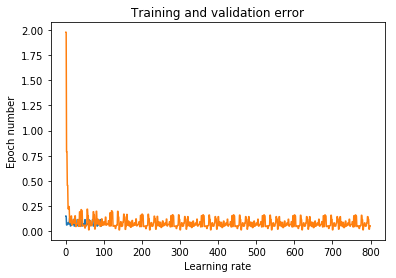

In [12]:
u = 2**(np.linspace(-25, 15, 40))
train_loss = model[1]
val_loss = model[2]
plt.plot(train_loss, label = 'Training')
plt.plot(val_loss, label = 'Validation')
#plt.loglog(u, val_loss[:40], label = 'val')
plt.title('Training and validation error')
plt.xlabel('Learning rate')
plt.ylabel('Epoch number')
plt.show()

# Evaluation of the results

In [13]:
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model[0](inputs)
        break


RuntimeError: CUDA out of memory. Tried to allocate 2.82 GiB (GPU 0; 11.91 GiB total capacity; 29.05 MiB already allocated; 2.58 GiB free; 973.50 KiB cached)

#### Collect classes

In [13]:
outputs = outputs.permute(0, 2, 1)
arg = torch.argmax(outputs, dim = 1)
label_batch = labels[0].detach().cpu().numpy()
pred_batch = torch.argmax(outputs[0], dim = 0).detach().cpu().numpy()

#### Confusion matrix

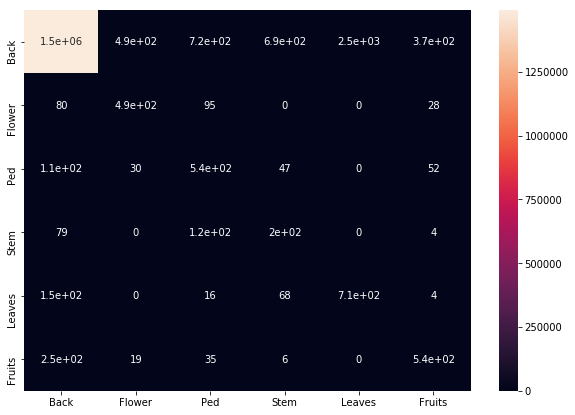

In [14]:
cm = confusion_matrix(label_batch, pred_batch)
df_cm = pd.DataFrame(cm, index = [i for i in classes],
      columns = [i for i in classes])
fig = plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [18]:
vol = torch.load('voxel_coord/voxels_05_shift6.pt').to(device)
vol[5*k:20*k,3] = arg[0].cpu()
#vol[:,3] = arg[0].cpu()

1029
1520
1010
3229
994


True

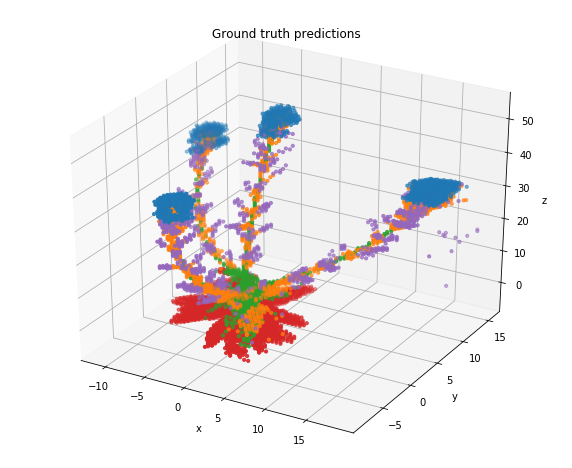

In [19]:
colors = ['r.', 'k.', 'g.', 'b.', 'o.']

fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_aspect('equal')
ax.set_title('Ground truth predictions')

corresp = [1,2,3,4,5]
for i in corresp:
    inds = vol[:,3] == corresp[i-1]
    inds = inds.cpu()
    print(np.count_nonzero(inds))
    pred_label = vol[inds].cpu()
    #vol[3,inds] = i
    ax.scatter3D(pred_label[:,0], pred_label[:,1], pred_label[:,2], colors[i-1], s=10)
    i += 1
    
volnp = vol[vol[:,3]!=0].cpu().numpy()
write_ply('preds_blur2.ply', [volnp[:,0], volnp[:,1], volnp[:,2], volnp[:,3]],
      ['x', 'y', 'z', 'label'])

693
787
397
943
846


True

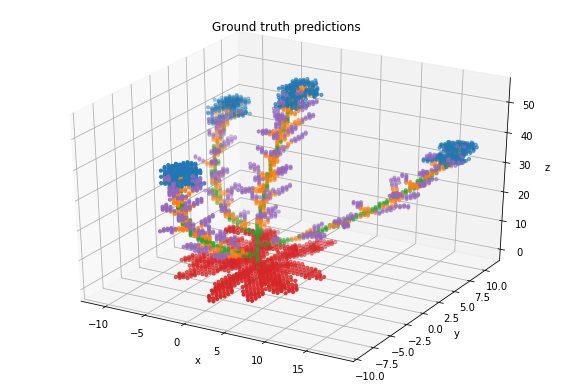

In [20]:
colors = ['r.', 'k.', 'g.', 'b.', 'o.']

fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_aspect('equal')
ax.set_title('Ground truth predictions')

gt_vol = torch.load('voxel_coord/voxels_05_shift6.pt').to(device)
gt_vol[5*k:20*k,3] = labels[0]
#gt_vol[:,3] = labels[0]

corresp = [1,2,3,4,5]
for i in corresp:
    inds = gt_vol[:,3] == corresp[i-1]
    inds = inds.cpu()
    print(np.count_nonzero(inds))
    gt_label = gt_vol[inds].cpu()
    #vol[3,inds] = i
    ax.scatter3D(gt_label[:,0], gt_label[:,1], gt_label[:,2], colors[i-1], s=10)
    i += 1
    
volnp = gt_vol[gt_vol[:,3]!=0].cpu().numpy()
write_ply('ground_truths.ply', [volnp[:,0], volnp[:,1], volnp[:,2], volnp[:,3]],
      ['x', 'y', 'z', 'label'])

In [41]:
a = model[0].state_dict().items()

In [58]:
a

odict_items([('weight', tensor([[[[ 0.0290,  0.0586, -0.0226,  0.0222, -0.0631, -0.0605, -0.0053,
            0.0960,  0.1375,  0.1971,  0.3289,  0.3712,  0.4336,  0.4342,
            0.4568,  0.3893,  0.4204,  0.4350,  0.4203,  0.4320,  0.5045,
            0.4712,  0.5054,  0.4149,  0.2937,  0.2637,  0.1426,  0.0343,
           -0.0881, -0.1098, -0.1623, -0.0986, -0.0622, -0.0390, -0.0205,
           -0.0270,  0.0285,  0.0242,  0.0426,  0.0569,  0.0476,  0.0419,
            0.0719,  0.0756,  0.1130,  0.1651,  0.1849,  0.2276,  0.2448,
            0.2023,  0.2093,  0.1983,  0.1776,  0.1893,  0.3453,  0.2547,
            0.2322,  0.1500,  0.2116,  0.1281,  0.1582,  0.1739,  0.2429,
            0.2541,  0.3048,  0.2885,  0.2571,  0.2442,  0.1899,  0.0964,
            0.0726,  0.0929],
          [ 0.2012,  0.2649,  0.2158,  0.2166,  0.2032,  0.1554,  0.1388,
            0.1548,  0.1361,  0.1342,  0.1312,  0.1116,  0.1003,  0.0364,
            0.0585,  0.0414,  0.0468,  0.0194, -0.0086,  0

In [63]:
a = list(model[0].parameters())[1].detach()
colors = ['r.', 'k.', 'g.', 'b.', 'o.']

gt_vol = torch.load('voxel_coord/voxels_05_shift6.pt').to(device)

for i in range(7):
    gt_vol[1000000:1500000,3] = a[0, :, i]
    gt_vol = gt_vol.cpu()

    volnp = gt_vol[torch.abs(gt_vol[:,3]) > 1e-3].cpu().numpy()
    write_ply('bias_%d.ply'%i, [volnp[:,0], volnp[:,1], volnp[:,2], volnp[:,3]],
          ['x', 'y', 'z', 'label'])

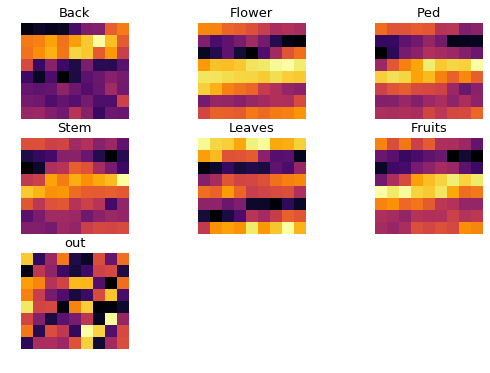

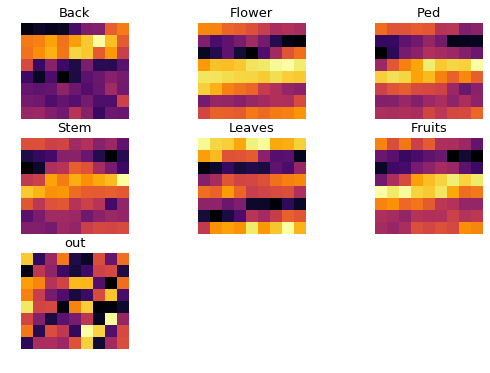

In [23]:
a = list(model[0].parameters())[0].detach()

g = alien.showclass()
g.title_list = classes + ['out']
weights = []
mean = []

for i in range(7):
    im = a[0, 0, i].cpu().numpy()
    im = im.reshape((8,9))
    weights.append(im)
    mean.append(im.mean())
    
g.showing(weights)

In [14]:
inputs.shape

torch.Size([1, 1500000, 72, 7])